In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as md
from scipy.stats import pearsonr #calculate correlation coefficient
from scipy import stats
import calendar
from fig_generator import *

In [23]:
# datos random

spotify_green = (29/255, 185/255, 84/255, 1)
spotify_black = (25/255, 20/255, 20/255, 1)
spotify_blue = (85/255, 156/255, 242/255, 1)
spotify_purple = (65/255, 0/255, 245/255, 1)
spotify_white = (1,1,1,1)

spotify_palette = [
                spotify_green,
                spotify_black,
                spotify_blue,
                spotify_purple,
                spotify_white
                ]
palette = sns.color_palette(spotify_palette, 5)
palette2 = sns.color_palette([spotify_green]*100, 100)

aa =  ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration']

# 1. Importar Datos

In [24]:
df = pd.read_csv("https://raw.githubusercontent.com/PabloReyesPolanco/spotify/master/Spotify%20Weekly.csv")
df = df.drop(["url","time_signature","key","mode"], axis = 1)
df = df[df.year > 2016].dropna(axis = 0).sort_values(["start","position"]).reset_index(drop=True)
df["duration"] = df["duration_ms"]
df['start'] = pd.to_datetime(df['start'], format = '%Y-%m-%d')

semanal = df.groupby("start", as_index = False).agg(
    danceability = ("danceability","mean"),
    energy = ("energy","mean"),
    loudness = ("loudness","mean"),
    speechiness = ("speechiness","mean"),
    acousticness = ("acousticness","mean"),
    instrumentalness = ("instrumentalness","mean"),
    liveness = ("liveness","mean"),
    valence = ("valence","mean"),
    tempo = ("tempo","mean"),
    duration = ("duration","mean"))

# semanal["id"] = [i for i in range(len(semanal))]

mensual = semanal.groupby(semanal['start'].dt.month).mean().reset_index()
mensual['start'] = mensual['start'].apply(lambda x: calendar.month_abbr[x])
aux = mensual.pop("start")
mensual=(mensual-mensual.mean())/mensual.std() # (mensual-mensual.min())/(mensual.max()-mensual.min())
# mensual = (mensual-mensual.max())/(mensual.min()-mensual.max())
mensual.insert(0, "start", aux)


In [25]:
n = 9
mensual["hue"] = [False]*n + [True]*(12-n)
a1 = mensual[mensual.hue == False].drop(["start","hue"], axis = 1).transpose().reset_index()
a2 = mensual[mensual.hue == True].drop(["start","hue"], axis = 1).transpose().reset_index()
a1 = pd.melt(a1, id_vars='index', value_name='valor').drop(["variable"], axis = 1)
a2 = pd.melt(a2, id_vars='index', value_name='valor').drop(["variable"], axis = 1)
a1["periodo"] = "inicio"
a2["periodo"] = "fin"
aux = pd.concat([a1,a2], axis = 0)
aux.columns = ["feature", "valor", "periodo"]

In [26]:
aux_mean = mensual.groupby("hue").mean().transpose().reset_index()
aux_std = mensual.groupby("hue").std().transpose().reset_index().fillna(0)
aux_mean.columns = ["feature", "inicio", "fin"]
aux_std.columns = ["feature", "inicio", "fin"]
# aux = pd.merge(aux_mean, aux_std,how = "inner", on="feature")
# aux

aux_mean = pd.melt(aux_mean, id_vars='feature', value_vars=["inicio","fin"], value_name='valor')
aux_mean.columns = ["feature","periodo","valor"]
aux_std = pd.melt(aux_std, id_vars='feature', value_vars=["inicio","fin"], value_name='valor')
aux_std.columns = ["feature","periodo","valor"]

In [27]:
for i in aa:
    g1 = mensual[mensual.hue == False]
    g2 = mensual[mensual.hue == True]
    g1_n, g2_n = len(g1), len(g2)
    if g2_n != 1:
        g1_mean, g2_mean = g1[i].mean(), g2[i].mean()
        g1_std, g2_std = g1[i].std(), g2[i].std()
    else:
        g1_mean, g2_mean = g1[i].mean(), int(g2[i])
        g1_std, g2_std = g1[i].std(), 0

    dif = g2_mean - g1_mean
    std = (g1_std**2/g1_n + g2_std**2/g2_n)**(1/2)
    intervalo = [dif - 1.96*std,dif +1.96*std]
    if intervalo[0]*intervalo[1] > 0:
        print(f"{i}: ")
        print(intervalo)

danceability: 
[-3.3278614528424004, -0.2037744697127606]
speechiness: 
[-3.2879312949066604, -0.35364977938555264]
tempo: 
[1.511795016775515, 2.3377837555062597]
duration: 
[-2.7845874337330008, -0.8741581950236235]


In [28]:
mean = df.drop_duplicates("track_name").mean()
std = df.drop_duplicates("track_name").std()
std/mean

<ipython-input-28-5a07f1c8fc73>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  mean = df.drop_duplicates("track_name").mean()


acousticness        1.048899
danceability        0.206647
duration            0.237507
duration_ms         0.237507
energy              0.260291
instrumentalness    6.333953
liveness            0.763157
loudness           -0.403625
position            0.564344
speechiness         0.911765
start                    NaT
streams             0.802342
tempo               0.244375
valence             0.459569
year                  0.0007
dtype: object

In [29]:
for i in aa:
    lenght = len(df)
    print(f"{i}: {len(df[(df[i] > mean[i] - std[i]) & (df[i] < mean[i] + std[i])])*100/lenght:.2f}%")

danceability: 71.12%
energy: 66.35%
loudness: 75.17%
speechiness: 88.05%
acousticness: 81.96%
instrumentalness: 97.45%
liveness: 87.50%
valence: 63.43%
tempo: 67.92%
duration: 81.38%


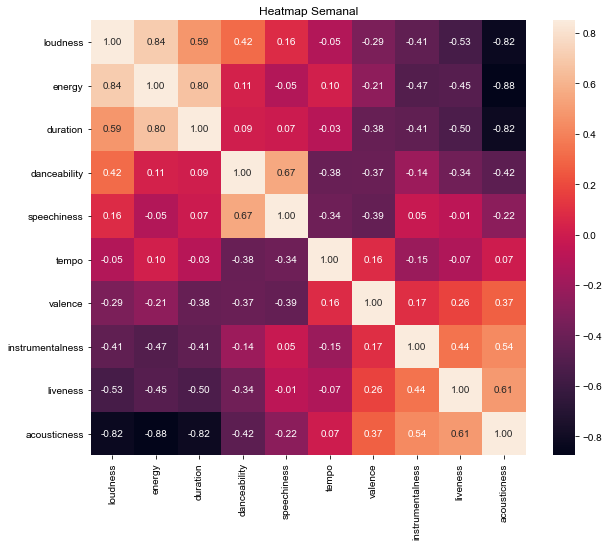

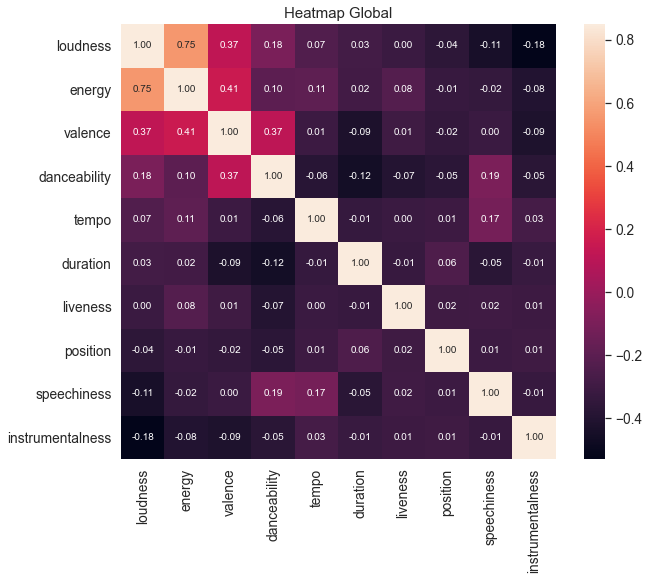

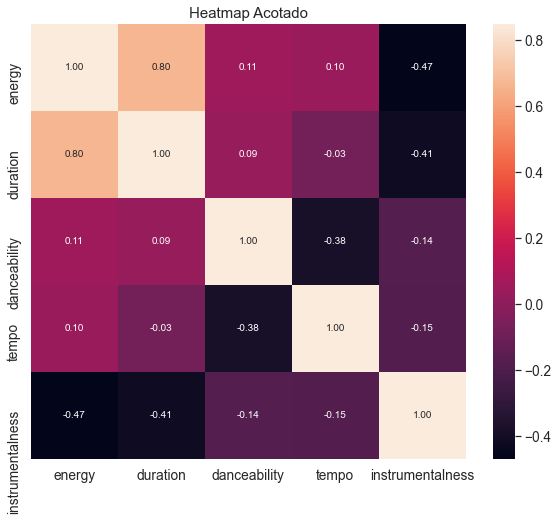

In [30]:
graficar(df,mensual,semanal)

# Pregunta 3: Efecto Tik Tok

In [31]:
tiktok = pd.read_csv("tiktok.csv").drop(["Unnamed: 0","track_id","artist_id","album_id"], axis =1)
tiktok = tiktok[["track_name"]+aa]
tiktok["plataforma"] = "tiktok"
spotify = df[["track_name"]+aa].copy()
spotify = spotify.drop_duplicates(["track_name"])
spotify["plataforma"] = "spotify"
stream = pd.concat([spotify,tiktok], axis = 0 )

aux = stream.pop("track_name")
aux2 = stream.pop("plataforma")
stream=(stream-stream.max())/(stream.min() -stream.max())# (mensual-mensual.min())/(mensual.max()-mensual.min())
stream.insert(0, "track_name", aux)
stream.insert(0, "plataforma", aux2)

spfy = stream[stream.plataforma == "spotify"]
ttok = stream[stream.plataforma == "tiktok"]
spfy = pd.melt(spfy[aa].transpose().reset_index(), id_vars='index', value_name='valor').drop(["variable"], axis = 1)
ttok = pd.melt(ttok[aa].transpose().reset_index(), id_vars='index', value_name='valor').drop(["variable"], axis = 1)
ttok["plataforma"] = "tiktok"
spfy["plataforma"] = "spotify"
comp = pd.concat([spfy,ttok], axis = 0)
comp.columns = ["feature", "valor", "plataforma"]


## Diferencia de medias entre los promedios de tik tok y los de spotify

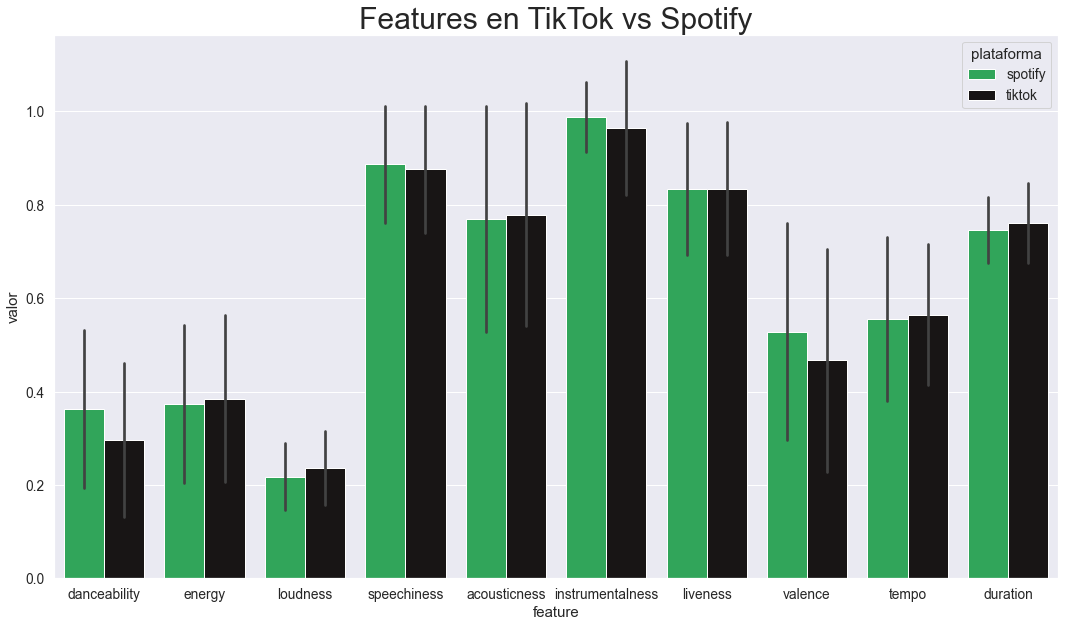

In [42]:
fig, ax = plt.subplots(figsize = (18,10))
sns.barplot(x='feature', y='valor', ci = "sd", data=comp, hue = "plataforma", palette = [spotify_green, spotify_black]).set_title("Features en TikTok vs Spotify", fontsize = 30)
plt.savefig(f"figuras/spotify vs tiktok")
# plt.close()

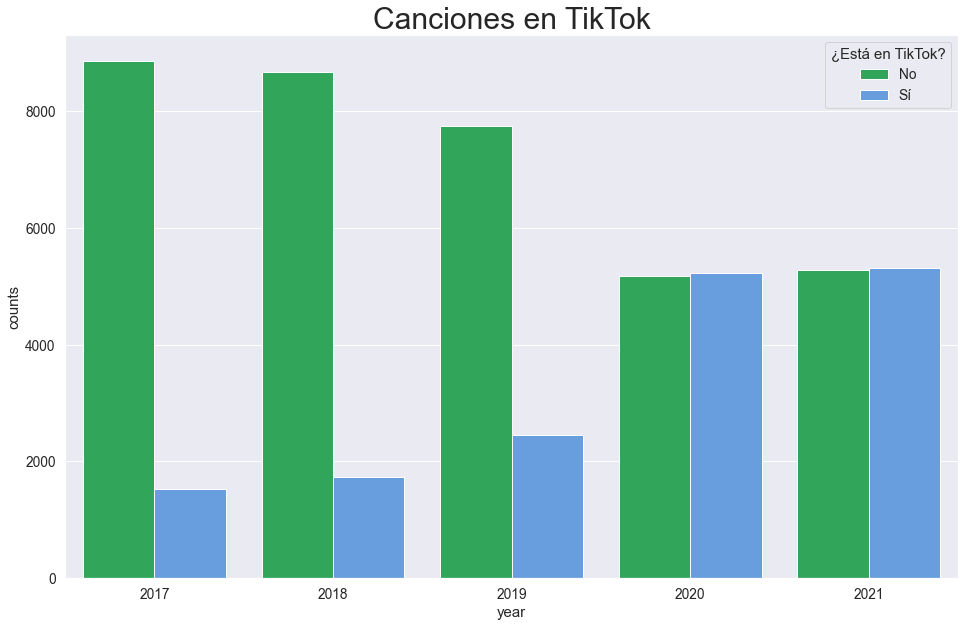

In [33]:
df["¿Está en TikTok?"] = df.track_name.apply(lambda x: "Sí" if x in tiktok.track_name.values else "No")
in_tiktok = df.groupby(["year", "¿Está en TikTok?"]).size().to_frame().reset_index()
in_tiktok.columns = ["year", "¿Está en TikTok?", "counts"]
fig, ax = plt.subplots(figsize = (16,10))
sns.barplot(x = "year", y = "counts" , hue = "¿Está en TikTok?", data = in_tiktok, palette = [spotify_green, spotify_blue]).set_title("Canciones en TikTok", fontsize = 30)
plt.savefig(f"figuras/canciones en tik tok")

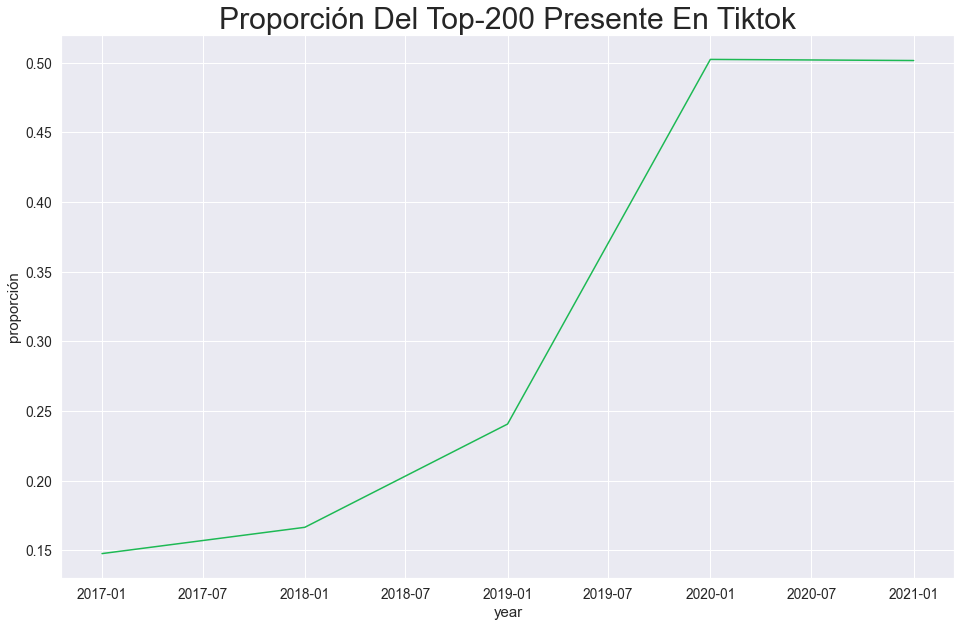

In [38]:
# proporcion en tik tok
prop = in_tiktok[in_tiktok["¿Está en TikTok?"] == "Sí"].copy()
prop["total"] = in_tiktok[in_tiktok["¿Está en TikTok?"] == "No"].counts.to_list()
prop["total"] = prop["total"] + prop["counts"]
prop["proporción"] = prop["counts"]/prop["total"]
fig, ax = plt.subplots(figsize = (16,10))
prop['year'] = pd.to_datetime(prop['year'], format = '%Y')
sns.lineplot(x = "year", y = "proporción", data = prop, color = spotify_green).set_title("Proporción del top-200 presente en TikTok".title(), fontsize = 30)
plt.savefig(f"figuras/proporcion en tik tok")

In [39]:
# pd.merge(tiktok.drop_duplicates("track_name"), df[["track_name", "streams"]],how = "inner", on="track_name").sort_values("streams", ascending = False)

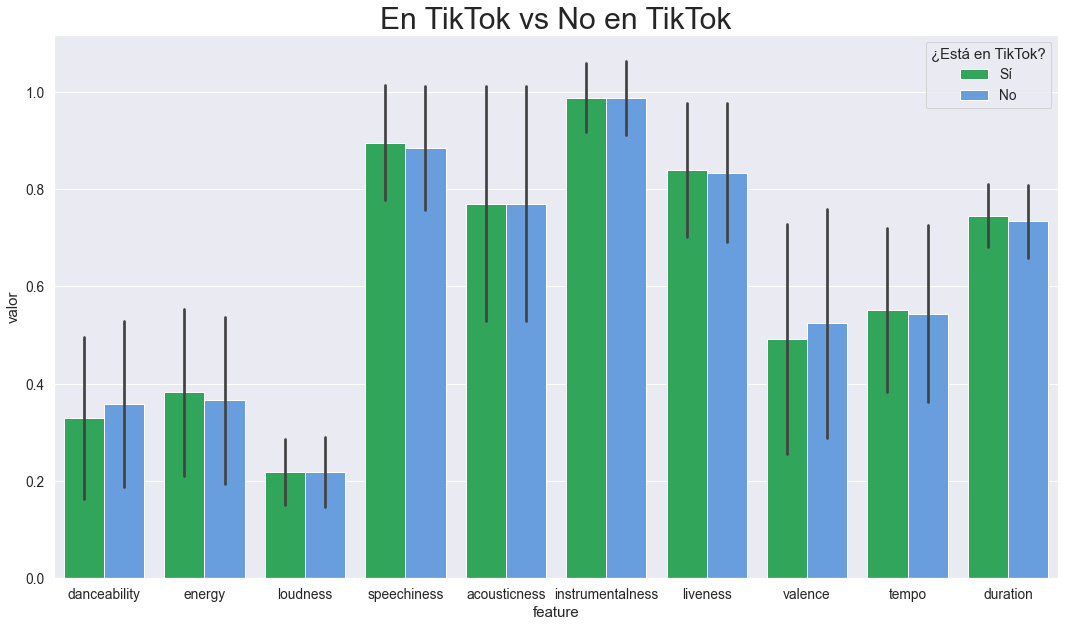

In [43]:
df["in_tiktok"] = df.track_name.apply(lambda x: True if x in tiktok.track_name.values else False)
df_vs = df.drop_duplicates("track_name")
df_vs = df_vs[["in_tiktok"] + aa]
aux = df_vs.pop("in_tiktok")
df_vs=(df_vs-df_vs.max())/(df_vs.min() -df_vs.max())# (mensual-mensual.min())/(mensual.max()-mensual.min())
df_vs.insert(0, "in_tiktok", aux)

in_tt = df_vs[df_vs.in_tiktok == True]
out_tt = df_vs[df_vs.in_tiktok == False]
in_tt = pd.melt(in_tt[aa].transpose().reset_index(), id_vars='index', value_name='valor').drop(["variable"], axis = 1)
out_tt = pd.melt(out_tt[aa].transpose().reset_index(), id_vars='index', value_name='valor').drop(["variable"], axis = 1)

in_tt["¿Está en TikTok?"] = "Sí"
out_tt["¿Está en TikTok?"] = "No"
vs = pd.concat([in_tt,out_tt], axis = 0)
vs.columns = ["feature", "valor", "¿Está en TikTok?"]

fig, ax = plt.subplots(figsize = (18,10))
sns.barplot(x='feature', y='valor', ci = "sd", data=vs, hue = "¿Está en TikTok?", palette = [spotify_green, spotify_blue]).set_title("En TikTok vs No en TikTok", fontsize = 30)
plt.savefig(f"figuras/En TikTok vs No en TikTok")



# Información Útil
* [Seaborn bonito](https://www.codecademy.com/article/seaborn-design-i)
* [Gráficos con barra de error](https://stackoverflow.com/questions/43159528/error-bars-with-seaborn-and-stripplot)
* [¿Cuándo una desviación estandar es pequeña?](https://math.stackexchange.com/questions/260617/how-to-determine-if-standard-deviation-is-high-low)

In [ ]:
n = 9
mensual["hue"] = [False]*n + [True]*(12-n)
a1 = mensual[mensual.hue == False].drop(["start","hue"], axis = 1).transpose().reset_index()
a2 = mensual[mensual.hue == True].drop(["start","hue"], axis = 1).transpose().reset_index()
a1 = pd.melt(a1, id_vars='index', value_name='valor').drop(["variable"], axis = 1)
a2 = pd.melt(a2, id_vars='index', value_name='valor').drop(["variable"], axis = 1)
a1["periodo"] = "inicio"
a2["periodo"] = "fin"
aux = pd.concat([a1,a2], axis = 0)
aux.columns = ["feature", "valor", "periodo"]